# Tutoriel : Télécharger, visualiser et interpréter les données GPM IMERG

Les données IMERG (Integrated Multi-satellitE Retrievals for GPM) proviennent du satellite GPM (Global Precipitation Measurement).
Elles fournissent des informations sur la pluie dans le monde entier.

Points clés :
- Chaque point de données représente la quantité de pluie en millimètres.
- Les données sont globales, ce qui permet d’étudier la pluie sur différents pays et régions.
- IMERG combine les mesures de plusieurs satellites pour obtenir des données fiables et détaillées.


Important : Pour utiliser les données IMERG, il est nécessaire de créer un compte Earthdata. C’est gratuit et vous pouvez le faire via : https://urs.earthdata.nasa.gov/users/new.

Le nom d’utilisateur et le mot de passe que vous créez peuvent ensuite être ajoutés au fichier .devcontainer dans ce dossier.

# Étape 1 : Importer les bibliothèques Python nécessaires

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
from netrc import netrc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm, ListedColormap
from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import ipywidgets as widgets
from ipyleaflet import Map, DrawControl
from ipyleaflet import Map, DrawControl, Rectangle
from matplotlib.ticker import AutoMinorLocator
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import h5py, requests, io
from netrc import netrc
from datetime import datetime, timedelta
import os
from pathlib import Path

# Étape 2 : Sélectionner une zone d’intérêt avec une carte interactive

In [2]:
def interactive_bbox_ipy(center=(5,5), zoom=5):
    bbox_output = widgets.Output()
    m = Map(center=center, zoom=zoom, layout=widgets.Layout(width='70%', height='500px'))

    # Outil pour dessiner un rectangle sur la carte
    draw = DrawControl(
        rectangle={"shapeOptions": {"color": "#0000FF"}},
        polygon={}, circle={}, polyline={}, marker={}
    )

    current_rectangle = None
    # Objet mutable pour sauvegarder la bbox (boîte englobante)
    bbox_coords = {"lat_min": None, "lat_max": None, "lon_min": None, "lon_max": None}

    def handle_draw(self, action, geo_json):
        nonlocal current_rectangle
        coords = geo_json['geometry']['coordinates'][0]
        lons = [c[0] for c in coords]
        lats = [c[1] for c in coords]

        # Mettre à jour le dictionnaire avec les nouvelles coordonnées
        bbox_coords["lon_min"] = min(lons)
        bbox_coords["lon_max"] = max(lons)
        bbox_coords["lat_min"] = min(lats)
        bbox_coords["lat_max"] = max(lats)

        # Supprimer l’ancien rectangle (si existant)
        if current_rectangle:
            m.remove_layer(current_rectangle)

        # Ajouter le nouveau rectangle sélectionné par l’utilisateur
        current_rectangle = Rectangle(
            bounds=[[bbox_coords["lat_min"], bbox_coords["lon_min"]],
                    [bbox_coords["lat_max"], bbox_coords["lon_max"]]],
            color="blue",
            fill_opacity=0.1
        )
        m.add_layer(current_rectangle)

        # Mettre à jour le tableau avec les coordonnées
        with bbox_output:
            bbox_output.clear_output()
            display(widgets.HTML(
                value=f"""
                <table style="border:1px solid black; border-collapse: collapse;">
                <tr><th style="border:1px solid black; padding:5px">Paramètre</th>
                    <th style="border:1px solid black; padding:5px">Valeur</th></tr>
                <tr><td style="border:1px solid black; padding:5px">lat_min</td><td style="border:1px solid black; padding:5px">{bbox_coords['lat_min']:.4f}</td></tr>
                <tr><td style="border:1px solid black; padding:5px">lat_max</td><td style="border:1px solid black; padding:5px">{bbox_coords['lat_max']:.4f}</td></tr>
                <tr><td style="border:1px solid black; padding:5px">lon_min</td><td style="border:1px solid black; padding:5px">{bbox_coords['lon_min']:.4f}</td></tr>
                <tr><td style="border:1px solid black; padding:5px">lon_max</td><td style="border:1px solid black; padding:5px">{bbox_coords['lon_max']:.4f}</td></tr>
                </table>
                """
            ))

    draw.on_draw(handle_draw)
    m.add_control(draw)

    title = widgets.HTML("<h3>Sélectionnez la zone d’intérêt</h3>")
    hbox = widgets.HBox([m, bbox_output])
    layout = widgets.VBox([title, hbox])
    display(layout)

    return bbox_coords  # le dictionnaire reste disponible après avoir dessiné

# Utilisation:
bbox_coords = interactive_bbox_ipy(center=(7,0), zoom=5)

## Étape 3 : Importer les données IMERG pour la zone sélectionnée

In [3]:
print('Les coordonnées lat/lon sélectionnées avec la carte interactive')
print(bbox_coords["lat_min"], bbox_coords["lat_max"], bbox_coords["lon_min"], bbox_coords["lon_max"])

def plot_gpm_imerg_box(year, month, day, hour, minute, 
                        lat_min=4, lat_max=16, lon_min=-6, lon_max=3,
                        bbox_coords=None):
    """
    Télécharge et trace les précipitations GPM IMERG pour un moment donné.
    Deux panneaux sont créés :
    - Gauche : carte globale (ou grande région)
    - Droite : zoom sur la zone définie par bbox_coords ou les limites fournies
    """
    # --- Vérification minute ---
    if minute not in [0, 30]:
        raise ValueError("Les fichiers IMERG existent uniquement pour hh:00 ou hh:30 UTC")
    
    # --- Connexion NASA ---
    secrets = netrc()
    username, _, password = secrets.authenticators("urs.earthdata.nasa.gov")
    
    # --- Temps de début et fin ---
    start_time = datetime(year, month, day, hour, minute)
    end_time = start_time + timedelta(minutes=29, seconds=59)
    
    # --- Segment et jour de l'année ---
    base_minutes = hour * 60 + minute
    segment_number = 90 + 30 * (base_minutes // 30 - 3)
    segment_str = f"{segment_number:04d}"
    day_of_year = f"{(start_time - datetime(year,1,1)).days + 1:03d}"
    
    # --- URL IMERG ---
    url = (
        f"https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"
        f"{year}/{day_of_year}/3B-HHR.MS.MRG.3IMERG."
        f"{start_time.strftime('%Y%m%d')}-S{start_time.strftime('%H%M%S')}"
        f"-E{end_time.strftime('%H%M%S')}.{segment_str}.V07B.HDF5"
    )
    print("URL de téléchargement :", url)

    # --- Télécharger et lire HDF5 ---
    response = requests.get(url, auth=(username, password))
    response.raise_for_status()
    hdf5_file = h5py.File(io.BytesIO(response.content), 'r')
    
    precip = hdf5_file['Grid/precipitation'][0,:,:]
    lat = hdf5_file['Grid/lat'][:]
    lon = hdf5_file['Grid/lon'][:]
    precip = np.ma.masked_where(precip < 0, precip).T
    
    # --- Sélection de la région globale et de la BBox ---
    lat_idx = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lon_idx = np.where((lon >= lon_min) & (lon <= lon_max))[0]
    lat_region = lat[lat_idx]
    lon_region = lon[lon_idx]
    precip_region = precip[np.ix_(lat_idx, lon_idx)]
    lon2d, lat2d = np.meshgrid(lon_region, lat_region)
    
    # --- Colormap discrète ---
    bounds = [0,0.5,2,5,10,15,25,40,100]
    colors = ["none","#add8e6","#0000ff","#00ff00","#ffff00","#ffa500","#ff0000","#ff69b4"]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(bounds, cmap.N)
    
    # --- Figure avec deux panneaux ---
    fig, axs = plt.subplots(1,2, figsize=(16,6),
                            subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Panneau gauche : région globale
    pcm1 = axs[0].pcolormesh(lon2d, lat2d, precip_region, cmap=cmap, norm=norm, shading='auto')
    axs[0].coastlines()
    axs[0].add_feature(cfeature.BORDERS)
    axs[0].set_extent([lon_min, lon_max, lat_min, lat_max])
    axs[0].set_title(f"Région globale\n{start_time.strftime('%Y-%m-%d %H:%M UTC')}")
    
    # Panneau droit : zoom sur BBox
    pcm2 = axs[1].pcolormesh(lon2d, lat2d, precip_region, cmap=cmap, norm=norm, shading='auto')
    axs[1].coastlines()
    axs[1].add_feature(cfeature.BORDERS)
    if bbox_coords is not None:
        axs[1].set_extent([bbox_coords["lon_min"], bbox_coords["lon_max"],
                           bbox_coords["lat_min"], bbox_coords["lat_max"]])
    else:
        axs[1].set_extent([lon_min, lon_max, lat_min, lat_max])
    axs[1].set_title("Zoom sur la BBox")
    
    # Barre de couleur
    cbar = fig.colorbar(pcm2, ax=axs, orientation='vertical', fraction=0.05, pad=0.02,
                        boundaries=bounds, ticks=bounds[:-1])
    cbar.set_label("Précipitation [mm/h]")
    
    plt.show()

Les coordonnées lat/lon sélectionnées avec la carte interactive
10.58287 12.734666 -5.710984 -2.460117


URL de téléchargement : https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2023/283/3B-HHR.MS.MRG.3IMERG.20231010-S000000-E002959.0000.V07B.HDF5


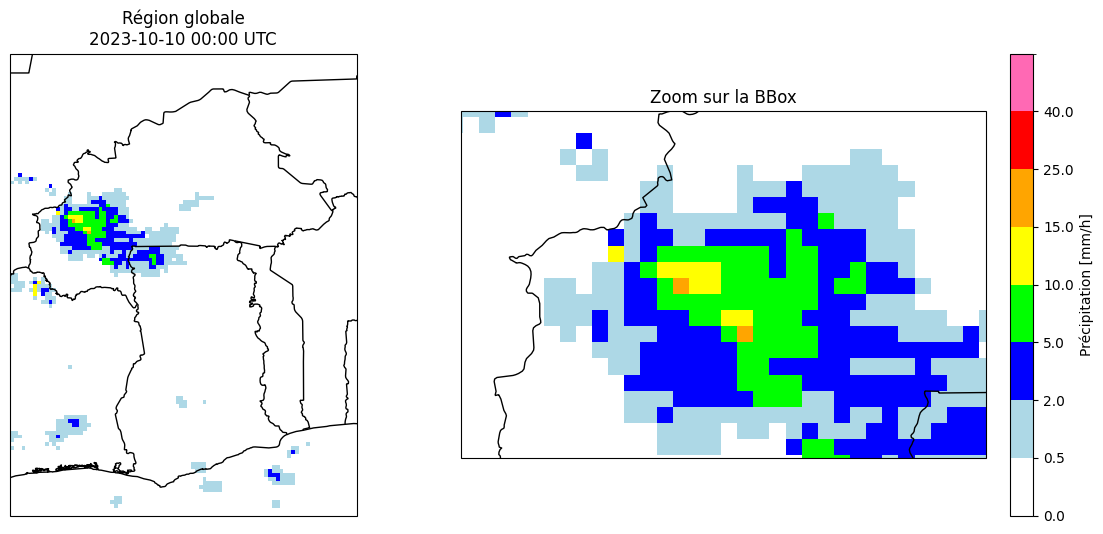

In [4]:
username = os.environ["NASA_USER"]
password = os.environ["NASA_PASS"]
plot_gpm_imerg_box(2023, 10, 10, 0, 0, bbox_coords=bbox_coords)

# Étape 4 : Visualiser différentes étapes temporelles pour la zone d’intérêt

In [13]:
def plot_gpm_imerg_timeseries(start_time, interval_min, n_steps, bbox_coords):
    """
    Affiche plusieurs images IMERG toutes les demi-heures pour une zone BBox donnée.
    
    start_time : datetime
    interval_min : int, intervalle entre les images (en minutes)
    n_steps : nombre de sous-graphes à afficher
    bbox_coords : dict contenant lat_min, lat_max, lon_min, lon_max
    """
    # --- Colormap discrète pour les précipitations ---
    bounds = [0,0.5,2,5,10,15,25,40,100]
    colors = ["none","#add8e6","#0000ff","#00ff00","#ffff00","#ffa500","#ff0000","#ff69b4"]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(bounds, cmap.N)
    
    # --- Authentification auprès de NASA Earthdata ---
    secrets = netrc()
    username, _, password = secrets.authenticators("urs.earthdata.nasa.gov")
    
    # --- Création de la figure avec plusieurs sous-graphes ---
    fig, axs = plt.subplots(1, n_steps, figsize=(5*n_steps,5),
                            subplot_kw={'projection': ccrs.PlateCarree()})
    
    if n_steps == 1:
        axs = [axs]  # assurer que axs est toujours une liste
    
    # --- Boucle sur chaque pas de temps ---
    for i in range(n_steps):
        current_time = start_time + timedelta(minutes=i*interval_min)
        hour, minute = current_time.hour, current_time.minute
        
        if minute not in [0,30]:
            raise ValueError("Les fichiers IMERG existent uniquement pour hh:00 ou hh:30 UTC")
        
        # --- Calcul du segment et du jour de l'année ---
        base_minutes = hour*60 + minute
        segment_number = 90 + 30*(base_minutes//30 -3)
        segment_str = f"{segment_number:04d}"
        day_of_year = f"{(current_time - datetime(current_time.year,1,1)).days + 1:03d}"
        end_time = current_time + timedelta(minutes=29, seconds=59)
        
        # --- Construction de l'URL de téléchargement ---
        url = (
            f"https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"
            f"{current_time.year}/{day_of_year}/3B-HHR.MS.MRG.3IMERG."
            f"{current_time.strftime('%Y%m%d')}-S{current_time.strftime('%H%M%S')}"
            f"-E{end_time.strftime('%H%M%S')}.{segment_str}.V07B.HDF5"
        )
        print("Téléchargement :", url)
        
        # --- Téléchargement et lecture du fichier HDF5 ---
        response = requests.get(url, auth=(username,password))
        response.raise_for_status()
        hdf5_file = h5py.File(io.BytesIO(response.content), 'r')
        
        precip = hdf5_file['Grid/precipitation'][0,:,:]
        lat = hdf5_file['Grid/lat'][:]
        lon = hdf5_file['Grid/lon'][:]
        precip = np.ma.masked_where(precip<0, precip).T  # masquage des valeurs invalides
        
        # --- Sélection de la zone BBox ---
        lat_idx = np.where((lat>=bbox_coords["lat_min"]) & (lat<=bbox_coords["lat_max"]))[0]
        lon_idx = np.where((lon>=bbox_coords["lon_min"]) & (lon<=bbox_coords["lon_max"]))[0]
        lat_region = lat[lat_idx]
        lon_region = lon[lon_idx]
        precip_region = precip[np.ix_(lat_idx, lon_idx)]
        lon2d, lat2d = np.meshgrid(lon_region, lat_region)
        
        # --- Tracé de la carte ---
        pcm = axs[i].pcolormesh(lon2d, lat2d, precip_region, cmap=cmap, norm=norm, shading='auto')
        axs[i].coastlines()
        axs[i].add_feature(cfeature.BORDERS)
        axs[i].set_extent([bbox_coords["lon_min"], bbox_coords["lon_max"],
                           bbox_coords["lat_min"], bbox_coords["lat_max"]])
        axs[i].set_title(current_time.strftime('%Y-%m-%d %H:%M UTC'))
    
    # --- Barre de couleur commune ---
    cbar = fig.colorbar(pcm, ax=axs, orientation='vertical', fraction=0.05, pad=0.02,
                        boundaries=bounds, ticks=bounds[:-1])
    cbar.set_label("Précipitations [mm/h]")
    plt.show()


Downloading: https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2023/283/3B-HHR.MS.MRG.3IMERG.20231010-S000000-E002959.0000.V07B.HDF5
Downloading: https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2023/283/3B-HHR.MS.MRG.3IMERG.20231010-S003000-E005959.0030.V07B.HDF5
Downloading: https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2023/283/3B-HHR.MS.MRG.3IMERG.20231010-S010000-E012959.0060.V07B.HDF5
Downloading: https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2023/283/3B-HHR.MS.MRG.3IMERG.20231010-S013000-E015959.0090.V07B.HDF5


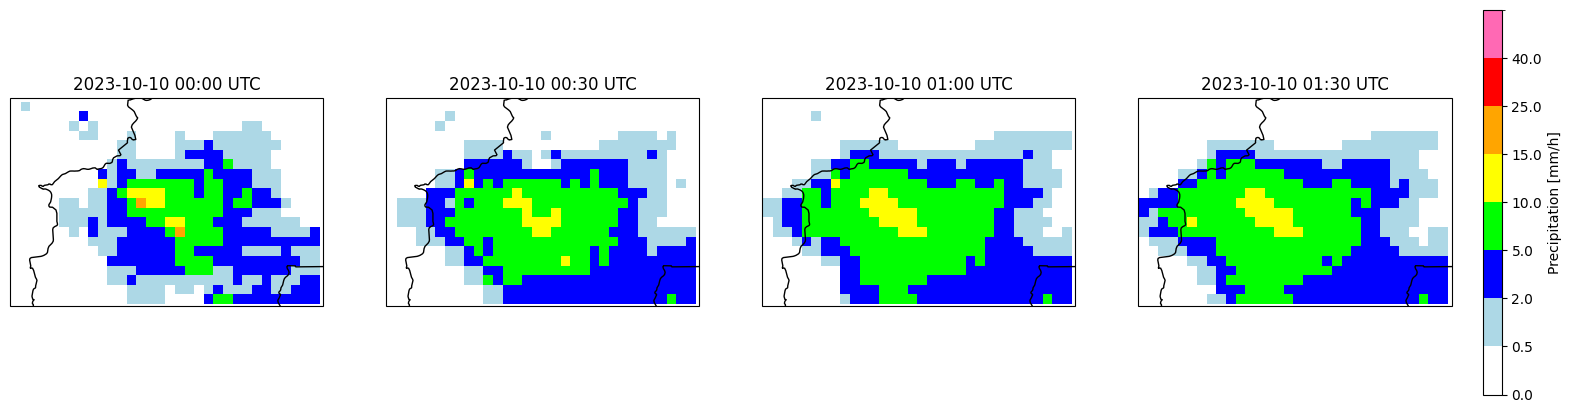

In [6]:
start = datetime(2023,10,10,0,0)
plot_gpm_imerg_timeseries(start_time=start, interval_min=30, n_steps=4, bbox_coords=bbox_coords)

# Étape 5 : Créer une animation des données IMERG

Ce script permet de visualiser sous forme d'animation les précipitations 
IMERG (GPM) sur une période donnée et éventuellement pour une région 
définie (bbox). Les précipitations sont affichées avec une palette de 
couleurs discrète spécifique pour mieux distinguer les intensités.

Les principales étapes :
1. Authentification auprès de NASA Earthdata.
2. Génération des timestamps selon l'intervalle choisi.
3. Téléchargement et lecture des fichiers HDF5 IMERG.
4. Sélection de la zone d'intérêt (bbox) si nécessaire.
5. Création d'une animation directement dans Jupyter Notebook avec 
   Matplotlib et Cartopy.
6. Application d'une colormap discrète pour une meilleure lisibilité.


In [7]:
def display_imerg_animation_colored(start_time, end_time, interval_min=30, bbox_coords=None):
    """
    Affiche une animation des précipitations IMERG 
    """

    # --- Authentification NASA Earthdata ---
    secrets = netrc()
    username, _, password = secrets.authenticators("urs.earthdata.nasa.gov")

    # --- Définition des couleurs discrètes ---
    # Les bounds définissent les intervalles de précipitations en mm/h
    bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]
    colors = ["none","#add8e6","#0000ff","#00ff00","#ffff00","#ffa500","#ff0000","#ff69b4"]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(bounds, cmap.N)

    # --- Génération des timestamps ---
    timestamps = []
    t = start_time
    while t <= end_time:
        timestamps.append(t)
        t += timedelta(minutes=interval_min)

    # --- Téléchargement des données IMERG ---
    precip_list = []
    lat = lon = None
    for t in tqdm(timestamps, desc="Téléchargement IMERG"):
        hour, minute = t.hour, t.minute
        if minute not in [0,30]:
            precip_list.append(None)
            continue

        base_minutes = hour*60 + minute
        segment_number = 90 + 30*(base_minutes//30 -3)
        segment_str = f"{segment_number:04d}"
        day_of_year = f"{(t - datetime(t.year,1,1)).days + 1:03d}"
        end_time_seg = t + timedelta(minutes=29, seconds=59)

        url = (
            f"https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"
            f"{t.year}/{day_of_year}/3B-HHR.MS.MRG.3IMERG."
            f"{t.strftime('%Y%m%d')}-S{t.strftime('%H%M%S')}"
            f"-E{end_time_seg.strftime('%H%M%S')}.{segment_str}.V07B.HDF5"
        )

        try:
            response = requests.get(url, auth=(username,password))
            response.raise_for_status()
            hdf5_file = h5py.File(io.BytesIO(response.content), 'r')

            precip = hdf5_file['Grid/precipitation'][0,:,:]
            lat = hdf5_file['Grid/lat'][:]
            lon = hdf5_file['Grid/lon'][:]
            precip = np.ma.masked_where(precip < 0, precip).T

            if bbox_coords:
                lat_idx = np.where((lat>=bbox_coords["lat_min"]) & (lat<=bbox_coords["lat_max"]))[0]
                lon_idx = np.where((lon>=bbox_coords["lon_min"]) & (lon<=bbox_coords["lon_max"]))[0]
                precip = precip[np.ix_(lat_idx, lon_idx)]
                lat = lat[lat_idx]
                lon = lon[lon_idx]

            precip_list.append(precip)

        except Exception as e:
            print(f"Erreur pour {t}: {e}")
            precip_list.append(None)

    # --- Création figure ---
    fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()})
    plt.close(fig)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    if bbox_coords:
        ax.set_extent([bbox_coords["lon_min"], bbox_coords["lon_max"],
                       bbox_coords["lat_min"], bbox_coords["lat_max"]])

    # --- Pcolormesh initial ---
    pcm = ax.pcolormesh(lon, lat, np.zeros_like(precip_list[0]), cmap=cmap, norm=norm, shading='auto')
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', ticks=bounds)
    cbar.set_label("Précipitation [mm/h]")

    # --- Fonction update pour l'animation ---
    def update(frame):
        data = precip_list[frame]
        if data is not None:
            pcm.set_array(data.flatten())
        ax.set_title(f"IMERG: {timestamps[frame].strftime('%Y-%m-%d %H:%M UTC')}")
        return [pcm]

    # --- Création animation ---
    ani = FuncAnimation(fig, update, frames=len(timestamps), interval=600, blit=False)

    return HTML(ani.to_jshtml())

In [8]:
start_time = datetime(2023,10,10,6,0)
end_time = datetime(2023,10,10,9,0)
bbox_coords = {"lat_min": 4, "lat_max": 16, "lon_min": -6, "lon_max": 3}
display_imerg_animation_colored(start_time, end_time, interval_min=30, bbox_coords=bbox_coords)

Téléchargement IMERG:   0%|          | 0/7 [00:00<?, ?it/s]

Téléchargement IMERG: 100%|██████████| 7/7 [00:27<00:00,  3.91s/it]


## Étape 6 : Créez un graphique des précipitations IMERG


In [9]:
def plot_imerg_bars_cumulative_interval(start_time, interval_min, n_steps, bbox_coords):
    """
    Trace un histogramme des précipitations moyennes sur le bbox avec cumulatif,
    à partir des fichiers IMERG fournis, en générant automatiquement les timestamps.
    """

    # Authentification NASA Earthdata
    secrets = netrc()
    username, _, password = secrets.authenticators("urs.earthdata.nasa.gov")

    # Génération automatique des timestamps 
    imerg_times = [start_time + timedelta(minutes=interval_min*i) for i in range(n_steps)]

    avg_precip_list = []

    # Boucle sur tous les timestamps IMERG 
    for t in tqdm(imerg_times, desc="IMERG timestamps"):
        # Vérification que le timestamp correspond aux fichiers IMERG (hh:00 ou hh:30)
        hour, minute = t.hour, t.minute
        if minute not in [0,30]:
            avg_precip_list.append(np.nan)
            continue

        # Calcul du segment et du jour de l'année
        base_minutes = hour*60 + minute
        segment_number = 90 + 30*(base_minutes//30 -3)
        segment_str = f"{segment_number:04d}"
        day_of_year = f"{(t - datetime(t.year,1,1)).days + 1:03d}"
        end_time = t + timedelta(minutes=29, seconds=59)

        # --- URL du fichier IMERG ---
        url = (
            f"https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"
            f"{t.year}/{day_of_year}/3B-HHR.MS.MRG.3IMERG."
            f"{t.strftime('%Y%m%d')}-S{t.strftime('%H%M%S')}"
            f"-E{end_time.strftime('%H%M%S')}.{segment_str}.V07B.HDF5"
        )

        try:
            # --- Téléchargement et lecture du fichier HDF5 ---
            response = requests.get(url, auth=(username,password))
            response.raise_for_status()
            hdf5_file = h5py.File(io.BytesIO(response.content), 'r')

            # Extraction des données
            precip = hdf5_file['Grid/precipitation'][0,:,:]
            lat = hdf5_file['Grid/lat'][:]
            lon = hdf5_file['Grid/lon'][:]
            precip = np.ma.masked_where(precip < 0, precip).T

            # --- Sélection de la BBox ---
            lat_idx = np.where((lat>=bbox_coords["lat_min"]) & (lat<=bbox_coords["lat_max"]))[0]
            lon_idx = np.where((lon>=bbox_coords["lon_min"]) & (lon<=bbox_coords["lon_max"]))[0]
            bbox_precip = precip[np.ix_(lat_idx, lon_idx)]

            # --- Calcul de l'intensité moyenne ---
            avg_precip = float(bbox_precip.mean())
            avg_precip_list.append(avg_precip)

        except Exception as e:
            print(f"Erreur pour {t}: {e}")
            avg_precip_list.append(np.nan)

    # --- Création du DataFrame ---
    df = pd.DataFrame({
        "timestamp": imerg_times,
        "avg_precip_mmph": avg_precip_list
    })

    # --- Calcul des précipitations cumulées ---
    cum_precip = [0]  # début à 0 mm
    for i in range(1, len(imerg_times)):
        # delta_h en heures (ex: 0.5 pour half-hourly)
        delta_h = (imerg_times[i] - imerg_times[i-1]).total_seconds() / 3600
        cum = cum_precip[-1] + avg_precip_list[i-1] * delta_h
        cum_precip.append(cum)
    df["cum_precip_mm"] = cum_precip

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.bar(df["timestamp"], df["avg_precip_mmph"], color='skyblue', 
            label="Intensité moyenne [mm/h]", width=0.02)  # bars plus étroites
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Intensité moyenne [mm/h]")
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())

    # --- Axe secondaire pour précipitations cumulées ---
    ax2 = ax1.twinx()
    ax2.plot(df["timestamp"], df["cum_precip_mm"], color='darkblue', label="Précipitations cumulées [mm]")
    ax2.set_ylabel("Précipitations cumulées [mm]")

    # --- Légende combinée ---
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.title(f"Précipitations IMERG sur le BBox")
    plt.show()

    return df

IMERG timestamps: 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


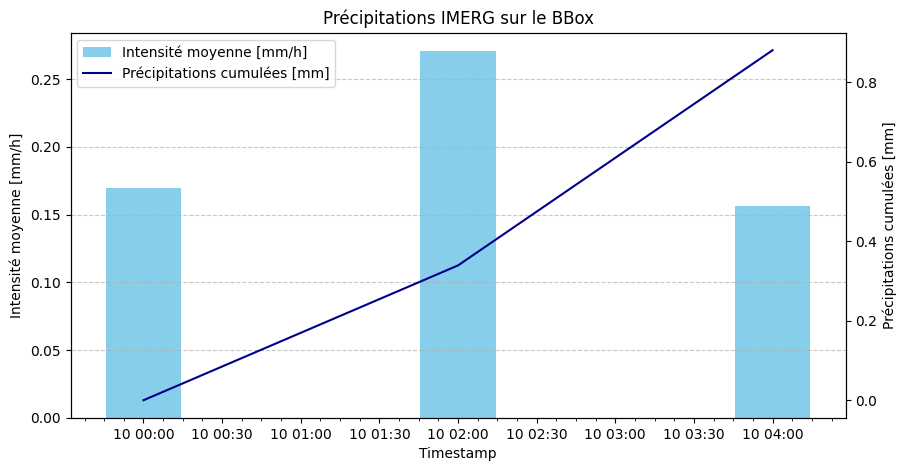

In [10]:
start_time = datetime(2023, 10, 10, 0, 0)
interval_min = 120  # intervalle 
n_steps = 3

df = plot_imerg_bars_cumulative_interval(
    start_time=start_time,
    interval_min=interval_min,
    n_steps=n_steps,
    bbox_coords=bbox_coords
)

# Étape 7 : Déterminer l’intensité des précipitations IMERG à des emplacements lat-lon spécifiques

In [11]:
def plot_imerg_points(points, start_time, interval_min, n_steps):
    """
    Récupère les précipitations IMERG pour des points précis et trace intensité + cumulatif.
    """

    # --- Authentification NASA Earthdata ---
    secrets = netrc()
    username, _, password = secrets.authenticators("urs.earthdata.nasa.gov")

    # --- Génération des timestamps ---
    imerg_times = [start_time + timedelta(minutes=interval_min*i) for i in range(n_steps)]

    # --- DataFrame pour stocker toutes les valeurs ---
    df = pd.DataFrame({"timestamp": imerg_times})

    # --- Boucle sur chaque point ---
    for point in points:
        lat_p = point["lat"]
        lon_p = point["lon"]
        nom_p = point["nom"]

        intensity_list = []

        for t in tqdm(imerg_times, desc=f"Récupération IMERG pour {nom_p}"):
            hour, minute = t.hour, t.minute
            if minute not in [0,30]:
                intensity_list.append(np.nan)
                continue

            base_minutes = hour*60 + minute
            segment_number = 90 + 30*(base_minutes//30 -3)
            segment_str = f"{segment_number:04d}"
            day_of_year = f"{(t - datetime(t.year,1,1)).days + 1:03d}"
            end_time = t + timedelta(minutes=29, seconds=59)

            url = (
                f"https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"
                f"{t.year}/{day_of_year}/3B-HHR.MS.MRG.3IMERG."
                f"{t.strftime('%Y%m%d')}-S{t.strftime('%H%M%S')}"
                f"-E{end_time.strftime('%H%M%S')}.{segment_str}.V07B.HDF5"
            )

            try:
                response = requests.get(url, auth=(username,password))
                response.raise_for_status()
                hdf5_file = h5py.File(io.BytesIO(response.content), 'r')

                precip = hdf5_file['Grid/precipitation'][0,:,:]
                lat = hdf5_file['Grid/lat'][:]
                lon = hdf5_file['Grid/lon'][:]
                precip = np.ma.masked_where(precip < 0, precip).T

                # Trouver l'indice le plus proche du point
                lat_idx = (np.abs(lat - lat_p)).argmin()
                lon_idx = (np.abs(lon - lon_p)).argmin()
                intensity = float(precip[lat_idx, lon_idx])
                intensity_list.append(intensity)

            except Exception as e:
                print(f"Erreur pour {nom_p} à {t}: {e}")
                intensity_list.append(np.nan)

        # Ajouter la colonne pour ce point
        df[nom_p + "_intensity_mmph"] = intensity_list

        # --- Calcul cumulatif ---
        cum_precip = [0]
        for i in range(1, len(imerg_times)):
            delta_h = (imerg_times[i] - imerg_times[i-1]).total_seconds() / 3600
            cum = cum_precip[-1] + intensity_list[i-1]*delta_h
            cum_precip.append(cum)
        df[nom_p + "_cum_mm"] = cum_precip

        # --- Plot ---
        fig, ax1 = plt.subplots(figsize=(10,4))
        ax1.bar(df["timestamp"], df[nom_p + "_intensity_mmph"], width=0.02, color='skyblue',
                label="Intensité moyenne [mm/h]")
        ax1.set_xlabel("Timestamp")
        ax1.set_ylabel("Intensité moyenne [mm/h]")
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

        ax2 = ax1.twinx()
        ax2.plot(df["timestamp"], df[nom_p + "_cum_mm"], color='darkblue', label="Précipitations cumulées [mm]")
        ax2.set_ylabel("Précipitations cumulées [mm]")

        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc="upper left")
        plt.title(f"Précipitations IMERG pour {nom_p}")
        plt.show()

    return df


Récupération IMERG pour Lomé: 100%|██████████| 3/3 [00:11<00:00,  3.74s/it]


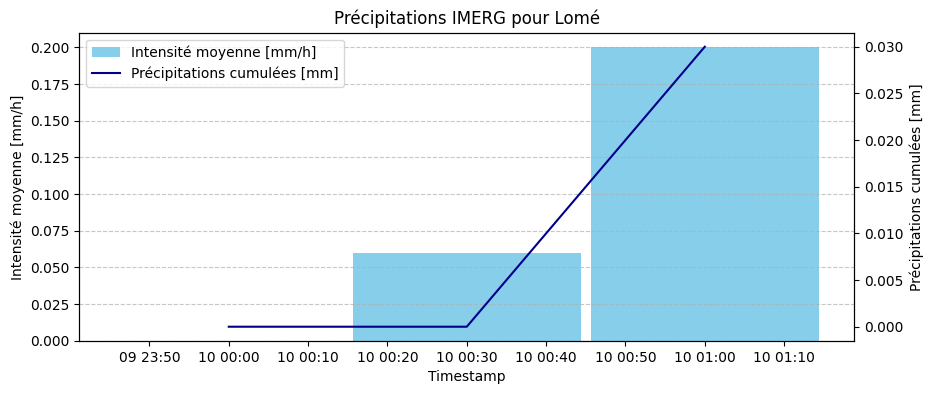

Récupération IMERG pour Ouagadougou: 100%|██████████| 3/3 [00:11<00:00,  3.67s/it]


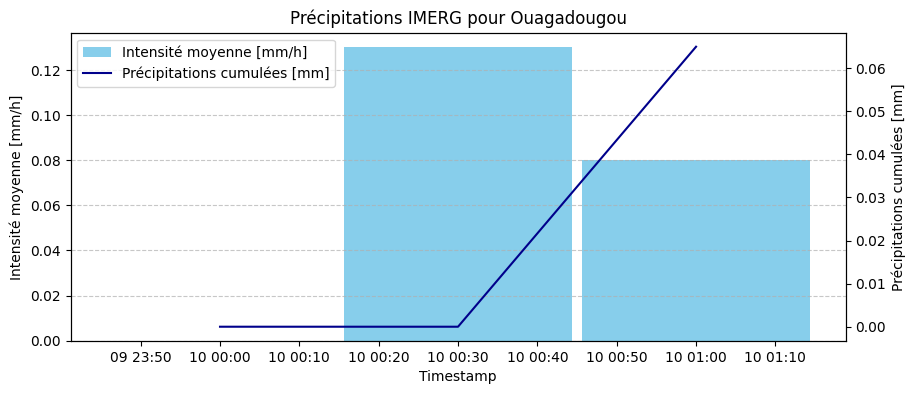

Récupération IMERG pour Nouna: 100%|██████████| 3/3 [00:13<00:00,  4.34s/it]


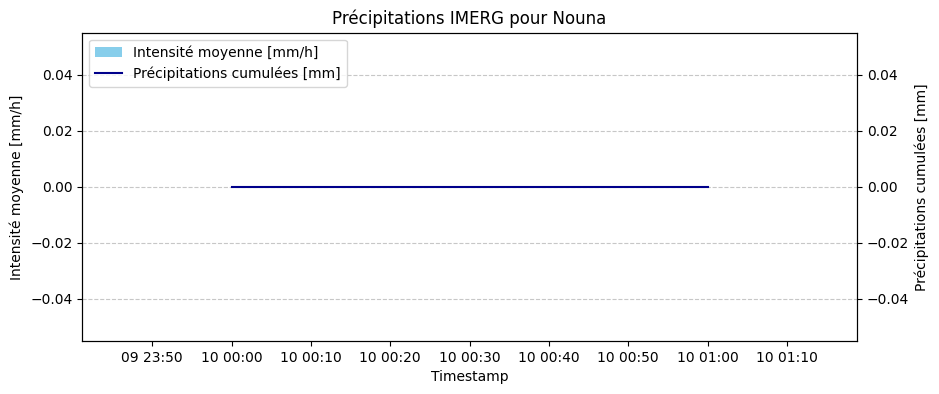

Les données ont été sauvegardées dans IMERG_points_timeseries.xlsx


In [15]:
# Choisissez les endroits qui vous intéressent

points = [
    {"nom": "Lomé", "lat": 6.13, "lon": 1.21},
    {"nom": "Ouagadougou", "lat": 12.37, "lon": -1.52},
    {"nom": "Nouna", "lat": 12.76, "lon": -3.84},
]

start_time = datetime(2023, 10, 10, 0, 0)           # Choisissez une heure de début
interval_min = 30                                   # Sélectionnez un intervalle de temps entre les images IMERG
n_steps = 3                                         # Sélectionnez le nombre d'horodatages que vous souhaitez collecter

df_IMERG_precipiation = plot_imerg_points(points, start_time, interval_min, n_steps)
df_IMERG_precipiation

# Sauvegarder le DataFrame en fichier Excel dans le même dossier que le notebook
excel_file = "IMERG_points_timeseries.xlsx"
df_IMERG_precipiation.to_excel(excel_file, index=True)
print(f"Les données ont été sauvegardées dans {excel_file}")